# Загрузка Pandas и очистка данных

In [57]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


In [58]:
def fdate1(lt):
    pattern=re.compile('\d\d[/]\d\d[/]\d\d\d\d')
    dates=[]
    for item in lt:
        item=item.strip()
        if pattern.search(item) is not None:
            item = pd.to_datetime(item,errors='ignore')
            dates.append(item)
    if dates !=[]:
        return dates
    else:
        return None
    
def fill_price (s):
    if s == '$':
        return 1
    elif s == '$$ - $$$':
        return 2
    elif s == '$$$$':
        return 3
    
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 10.5)
    upper_bound = quartile_3 + (iqr * 10.5)
    return [lower_bound,upper_bound]

def find_item_single(cell):
    if item == cell:
        return item
    return 0


# Предобработка данных

In [59]:
data = pd.read_csv('main_task.csv')


## Приводим стиль кухни к списку
data['Cuisine Style'] = data['Cuisine Style'][data['Cuisine Style'].isna()==False].\
apply(lambda s:s[1:-1].replace("'",'').replace(" ",'').split(','))
## Новый показатель - "Количество представленных кухонь".
data['Cuisine Style_num'] = data['Cuisine Style'][data['Cuisine Style'].isna() == False].apply(lambda l:len(l))
# Пустоты в кухнях заменяем на самую частую в этом городе
for city in data.City.unique():
    city_cuis_m = (data[data.City == city].explode('Cuisine Style')['Cuisine Style'].value_counts().index[0])
    data.loc[data.City == city,['Cuisine Style']] = data.loc[data.City == city,['Cuisine Style']].\
    fillna(city_cuis_m)    
# Путоты в количествах кухонь заполняем средним по городу
for city in data.City.unique():
    city_cuis_len_m = round(data[(data.City == city)&(data.City.isna() == False)]['Cuisine Style_num'].mean(),2)
    data.loc[data.City == city,['Cuisine Style_num']] = data.loc[data.City == city,['Cuisine Style_num']].\
    fillna(city_cuis_len_m)
data['Cuisine Style_num']

    
## Пустоты в количестве отзывов заменяем на среднее по городам
for city in data['City'].unique():
    data.loc[data.City == city, ['Number of Reviews']] = data.loc[data.City == city, ['Number of Reviews']].\
    fillna(round(data.loc[data.City == city, ['Number of Reviews']].median(),2))
    
    
## Новый показатель - Количество дней между отзывами. 
data['Reviews'] = data['Reviews'].apply(lambda s:s[1:-1].replace("'",'').replace("[",'').replace("]",'').\
                                        strip().split(','))
data['Reviews'] = data['Reviews'].apply(fdate1)
data['Reviews_num']=data['Reviews'][data['Reviews'].isna()==False].apply(lambda l:len(l))
data['Review_1'] = data[data['Reviews_num'] == 2]['Reviews'].apply(lambda l:l[0])
data['Review_2'] = data[data['Reviews_num'] == 2]['Reviews'].apply(lambda l:l[1])
data['Reviews_dist'] = data['Reviews'][data['Reviews_num'] == 2].apply(lambda l:(l[0]-l[1]).days)
med_1 = data['Reviews'][data['Reviews_num'] == 2].apply(lambda l:(l[0]-l[1]).days).median()
# Определяем выбросы по IQR и заменяем на медиану
lb_r,ub_r = outliers_iqr(data['Reviews_dist'][data['Reviews_dist'].isna() == False])
data['Reviews_dist'] = data['Reviews_dist'][data['Reviews_dist'].isna() == False]\
                                           [(data['Reviews_dist']< ub_r)&(data['Reviews_dist']> lb_r)]
data['Reviews_dist'] = data['Reviews_dist'].fillna(med_1)


## Новый показатель - "Количество дней от последнего отзыва до сегодя".
now = datetime.datetime.now()
data['Review_dist_to_now'] = data['Review_1'][data['Review_1'].isna()==False].apply(lambda l:(now-l).days)
# Определяем выбросы по IQR и заменяем на медиану
lb_rd,ub_rd = outliers_iqr(data['Review_dist_to_now'][data['Review_dist_to_now'].isna() == False])
data['Review_dist_to_now'] = data['Review_dist_to_now'][data['Review_dist_to_now'].isna()==False]\
[(data['Review_dist_to_now']> lb_rd) & (data['Review_dist_to_now'] < ub_rd)]
med = data['Review_1'][data['Review_1'].isna()==False].apply(lambda l:(now-l).days).median()
data['Review_dist_to_now'] = data['Review_dist_to_now'].fillna(med)


# Выкидываем выбросы из Ranking рассчитанные по IQR и заменяем пустоты на среднее
mean_ranking = data['Ranking'].mean()
ub_rank = outliers_iqr(data['Ranking'])[1]
data['Ranking'] = data['Ranking'][data['Ranking']<ub_rank]
data['Ranking'] = data['Ranking'].fillna(mean_ranking)


## Новый показатель "Отношение Ranking к количеству ресторанов в городе"
number_of_restaurants  = data.City.value_counts()
data['n_restaurants_per_city'] = data.City.apply(lambda x: number_of_restaurants.loc[x])
data['ranking_per_n_r_city'] = data.Ranking / data.n_restaurants_per_city
## Новый показатель "Отношение Ranking к количеству ресторанов в городе помноженное на Number of Reviews"
data['ranking_per_n_r_city_to_reviews'] = data['ranking_per_n_r_city']*data['Number of Reviews']
data['ranking_per_n_r_city_to_reviews']

## Новый показатель "Отношение Ranking к количеству кухонь"
data['Rank_to_num_cuis']=data['Ranking']/data['Cuisine Style_num']

## Новый показатель "Отношение Ranking к Number of Reviews"
data['Rank_to_num_rev']=data['Ranking']/data['Number of Reviews']

## Новый показатель "Отношение n_restaurants_per_city к Number of Reviews"
data['n_res_to_num_rev']=data['n_restaurants_per_city']/data['Number of Reviews']

## Новый показатель "Отношение n_restaurants_per_city к Cuisine Style_num"
data['Rank_to_cus_num']=data['n_restaurants_per_city']/data['Cuisine Style_num']

## Новый показатель "Отношение Number of Reviews к Review_dist_to_now"
data['test_2'] = data['Number of Reviews']/data['Review_dist_to_now']


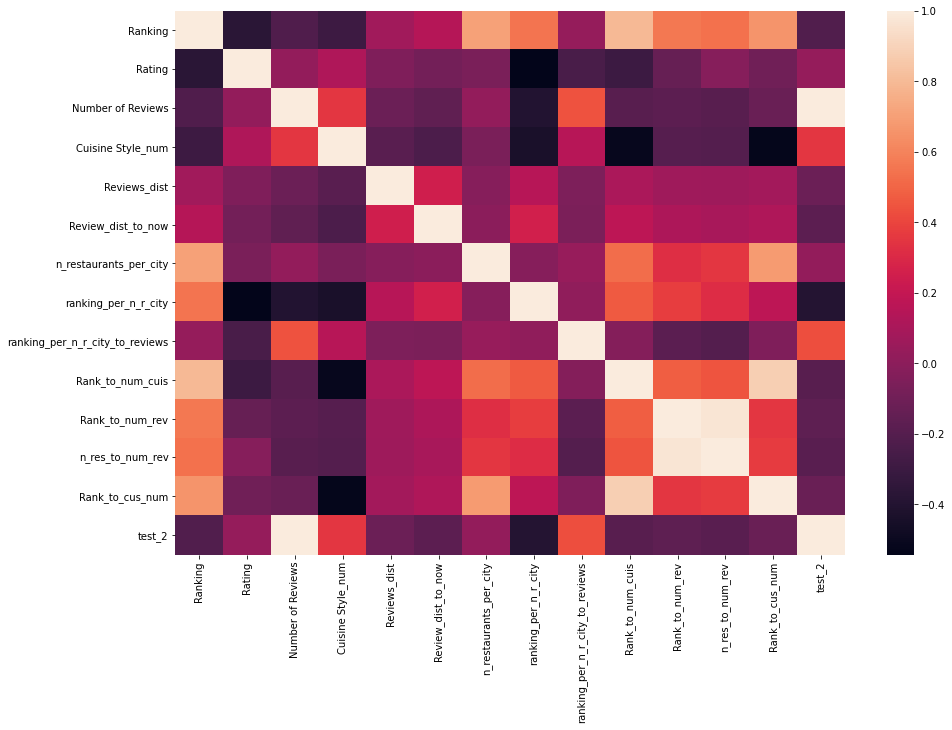

In [60]:
data_corr = data.drop(['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA',\
                    'Reviews_num','Review_1','Review_2','Price Range'],axis=1)
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_corr.corr())

In [61]:
## Новый показатель - "Уровень цен, количественный". Пустоты заменяем на медиану
data['Price Range'] = data['Price Range'][data['Price Range'].isna() == False].apply(fill_price)
data['Price Range'] = data['Price Range'].fillna(data['Price Range'].value_counts().index[0])
for item in data['Price Range'].unique():
    data[item] = data['Price Range'].apply(find_item_single)

## Города переводим в dummy
dummy_City = pd.get_dummies(data.City, dummy_na = True)
data = pd.concat([data,dummy_City],axis=1)

In [62]:
# Удаляем нечисловые признаки
data_1 = data.drop(['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA',\
                    'Reviews_num','Review_1','Review_2','Price Range'],axis=1)
data_1.head(5)

,Ranking,Rating,Number of Reviews,Cuisine Style_num,Reviews_dist,Review_dist_to_now,n_restaurants_per_city,ranking_per_n_r_city,ranking_per_n_r_city_to_reviews,Rank_to_num_cuis,...,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,NaN
0,5570.0,3.5,194.0,3.00,41.0,1206.0,4897,1.137431,220.661630,1856.666667,...,0,0,1,0,0,0,0,0,0,0
1,1537.0,4.0,10.0,3.18,382.0,1384.0,820,1.874390,18.743902,483.333333,...,0,0,0,0,0,1,0,0,0,0
2,353.0,4.5,688.0,7.00,2.0,1198.0,5757,0.061317,42.185861,50.428571,...,0,0,0,0,0,0,0,0,0,0
3,3458.0,5.0,3.0,2.94,55.0,1295.0,2155,1.604640,4.813921,1176.190476,...,0,0,0,0,0,0,0,0,0,0
4,621.0,4.0,84.0,3.00,272.0,1249.0,893,0.695409,58.414334,207.000000,...,0,0,0,0,0,0,0,0,0,0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [63]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data_1.drop(['Rating'], axis = 1)
y = data_1['Rating']

In [7]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [64]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [9]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [65]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [66]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2059125


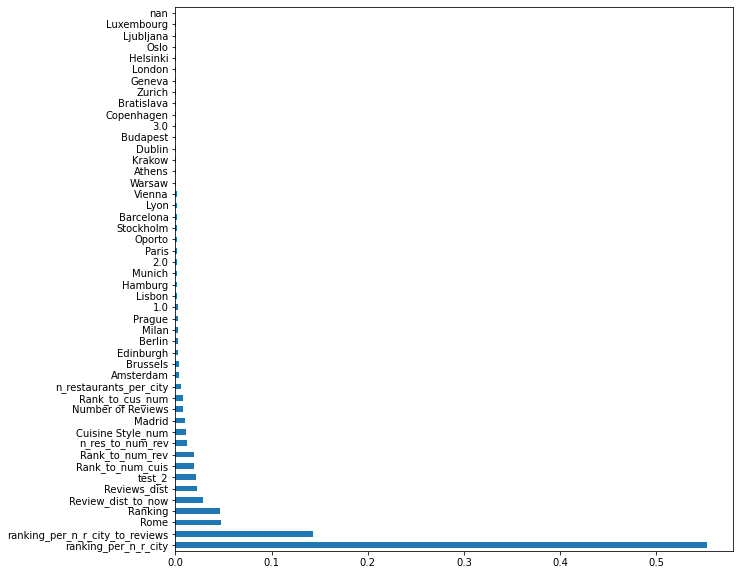

In [67]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(60).plot(kind='barh')